# Construction of an artificial (but realistic) image

Before we move on to looking at a real image, let's spend a few minutes getting
comfortable with what each of the different sources of counts look like in an
artificial image. The advantage is that we can control how much of each count
source goes into the image. Looking at extreme examples can help build an
understanding of what's going on in your images.

## Imports

Almost all of the notebooks in this tutorial will start with the import of the
Python packages needed for that notebook. Less widely used packages may also need to be installed. The lines below set up
[matplotlib](https://matplotlib.org/), a widely used plotting package, and install photoutils, a package used for image analysis based on IRAF.

In [19]:
!pip install photutils

In [20]:
import os

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from photutils.aperture import EllipticalAperture

In [21]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)

# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

The Python file referenced below, `convenience_functions.py`, contains a
few functions for convenient display of images in a notebook.

You can get a copy of this file a few ways.

1. If you are running the notebooks in your browser then this link will open the
file in another Jupyter Lab tab: [convenience_functions.py](convenience_functions.py). You can
also read/edit it in your preferred editor, but it's handy to know that editing
Python files in the Jupyter notebook environment is possible.
2. If you are reading the book online you can view a copy of the file
here: [convenience_functions.py](https://github.com/astropy/ccd-reduction-and-photometry-guide/blob/main/notebooks/convenience_functions.py)
3. If you want a copy of the file without doing a copy/paste, you can
download or clone this repository, including the notebooks and code,
at [https://github.com/astropy/ccd-reduction-and-photometry-guide](https://github.com/astropy/ccd-reduction-and-photometry-guide)
(click on the green "Code" button for options)


In [38]:
from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


## Start: a blank image

We'll begin with the simplest possible image: an array of zeros. The dimensions
of the image below are chosen to match some real images we'll be working with
later.

In [23]:
synthetic_image = np.zeros([1000, 1000])

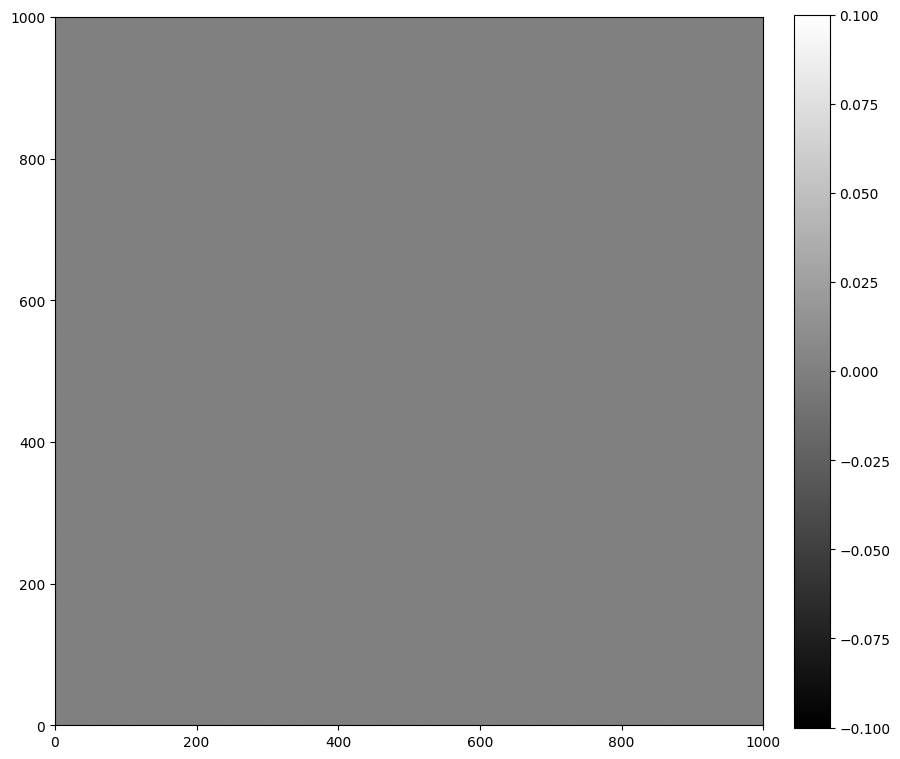

In [39]:
show_image(synthetic_image, cmap='gray')

## Add some read noise

With each of the things we add, we'll write a small function for adding so that
it's easier to experiment with different values. Read noise has a Gaussian
distribution; the standard deviation of the Gaussian (in counts) is the read
noise (in electrons) divided by the gain (in electrons per count). Read noise is
almost always given in electrons.

Note that each time you run this function you'll get a different set of pixels
so that it behaves like real noise.

In [25]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.

    Parameters
    ----------

    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape

    noise = noise_rng.normal(scale=amount/gain, size=shape)

    return noise

<Figure size 640x480 with 0 Axes>

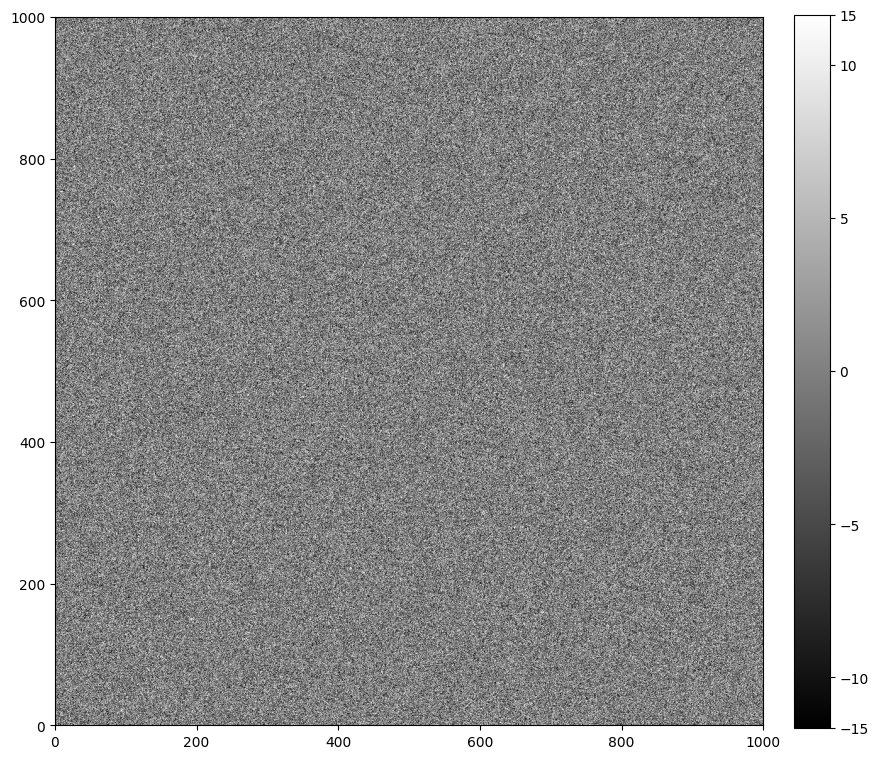

In [40]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
show_image(noise_im, cmap='gray')

##  Bias

Bias is an offset voltage (which translates into some non-zero number of counts)
added to every pixel in the image to ensure that when voltages are converted to
counts there is never a negative count. Note that in the noise image above, some
counts are positive and some are negative, as you would expect for a Gaussian
distribution centered on zero. Pixel values are typically read out from the
electronics as *positive* numbers, though. Adding a constant voltage, which
corresponds to a constant, positive number, ensures that even an image which
consists entirely of noise has no negative values.

The bias value is roughly the same across the CCD chip, though it's not uncommon
to have "bad" columns and pixels in which the bias level is consistently offset
from the rest of the chip.

To model a bias image, we create a uniform array and, optionally, add in some
"bad" columns. The bad columns are exaggerated here to ensure they are visible.

The bad columns in a CCD are typically stable over a very long time. A random
number generator is used below to pick which columns in our CCD are bad, but
we'll use a seed to make sure that each time we generate the bias we get the
same bad columns (and pixel values within the bad columns).

This stability is what makes it possible to correct for the effect in real
images.

Finally, note that the bias doesn't depend on exposure time. That's because a
bias exposure is a zero-second exposure in which the camera simply reads the
chip out.

In [27]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.

    Parameters
    ----------

    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value

    # If we want a more realistic bias we need to do a little more work.
    if realistic:
        shape = image.shape
        number_of_colums = 5

        # We want a random-looking variation in the bias, but unlike the readnoise the bias should
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])

        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern

    return bias_im


Text(0.5, 1.0, 'Bias alone, bad columns included')

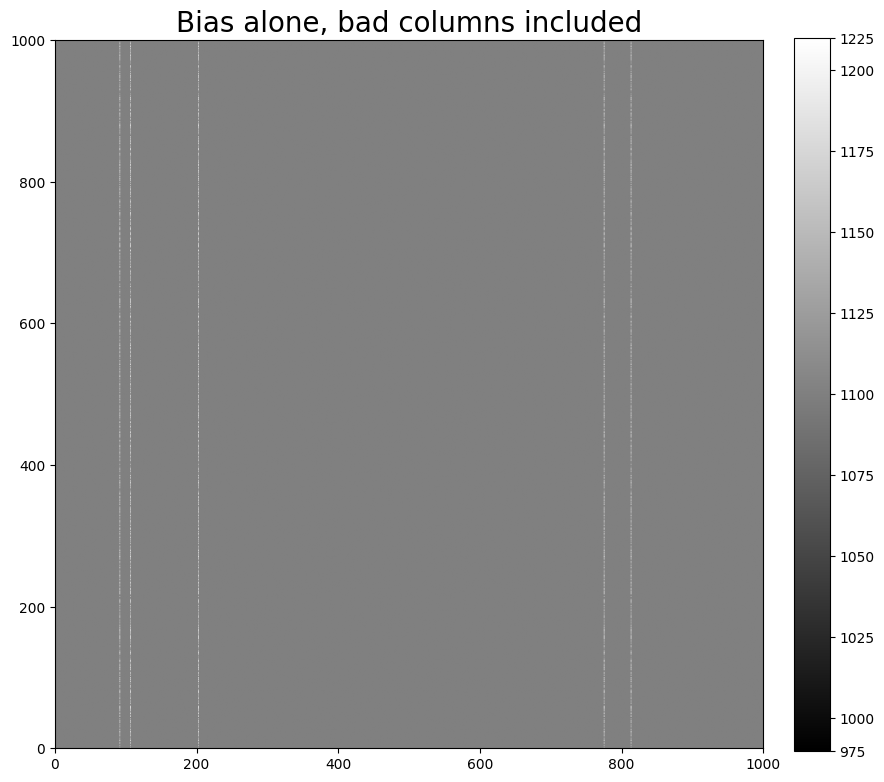

In [41]:
bias_only = bias(synthetic_image, 1100, realistic=True)
show_image(bias_only, cmap='gray', figsize=(10, 10))
plt.title('Bias alone, bad columns included', fontsize='20')

Text(0.5, 1.0, 'Realistic bias frame (includes read noise)')

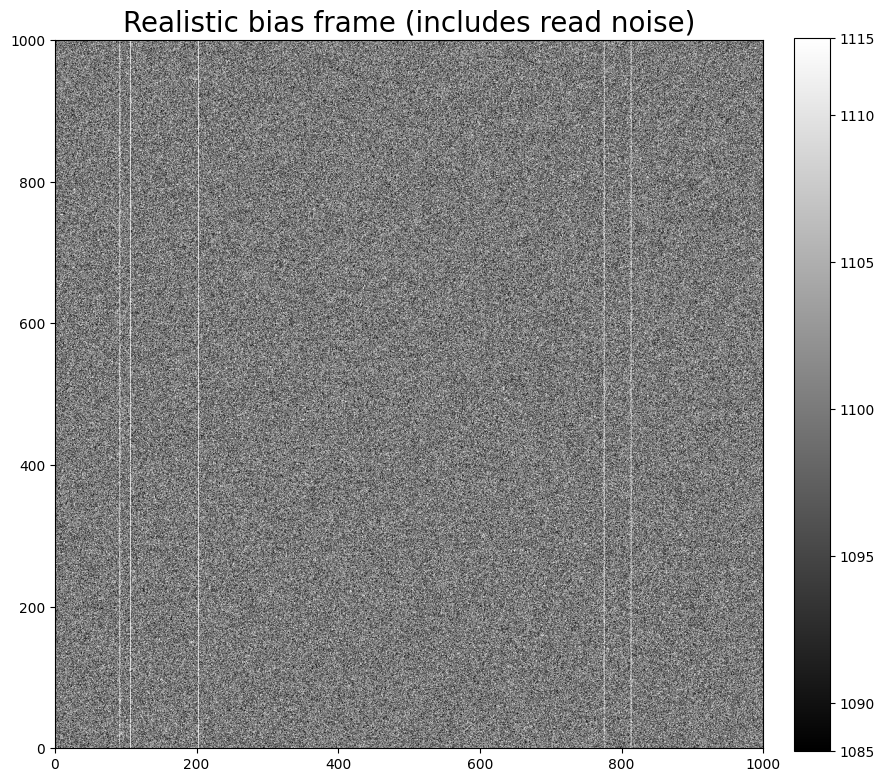

In [42]:
bias_noise_im = noise_im + bias_only
show_image(bias_noise_im, cmap='gray', figsize=(10, 10))
plt.title('Realistic bias frame (includes read noise)', fontsize='20')

## Dark current

Dark current depends on the temperature of the sensor. The amount of dark counts
in an image also depends on the exposure time. Dark current is typically very
small (0.1 electrons/pixel/second or less). Dark counts in this function are
calculated by multiplying the input dark current by the input exposure time
after converting the dark current unit from electrons to counts using the gain.

A small fraction of pixels are "hot": their dark current is much larger than the
rest of the pixels. Hot pixels are modeled here by choosing a subset of the
pixels to have a dark current 10,000 times larger than the input dark current.
This exaggerates the effect to make those pixels more visible.

The location and current of hot pixels is typically stable over long periods of
time, which makes it straightforward to remove their effect from science images
by subtracting them out.

A dark frame (or dark image) is an image taken with the camera shutter closed.

The function below simulates dark current only, i.e. it does *not* simulate the
read noise that is a part of any actual dark frame from a CCD.

Note that the simulation dark image looks noisy even though it doesn't include
read noise. This is because the number of electrons generated obey a Poisson
distribution.

In [43]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.
    """

    # dark current for every pixel; we'll modify the current for some pixels if
    # the user wants hot pixels.
    base_current = current * exposure_time / gain

    # This random number generation should change on each call.
    dark_im = noise_rng.poisson(base_current, size=image.shape)

    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should
        # ensure they are visible.
        y_max, x_max = dark_im.shape

        n_hot = int(0.0001 * x_max * y_max)

        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)

        hot_current = 10000 * current

        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain
    return dark_im

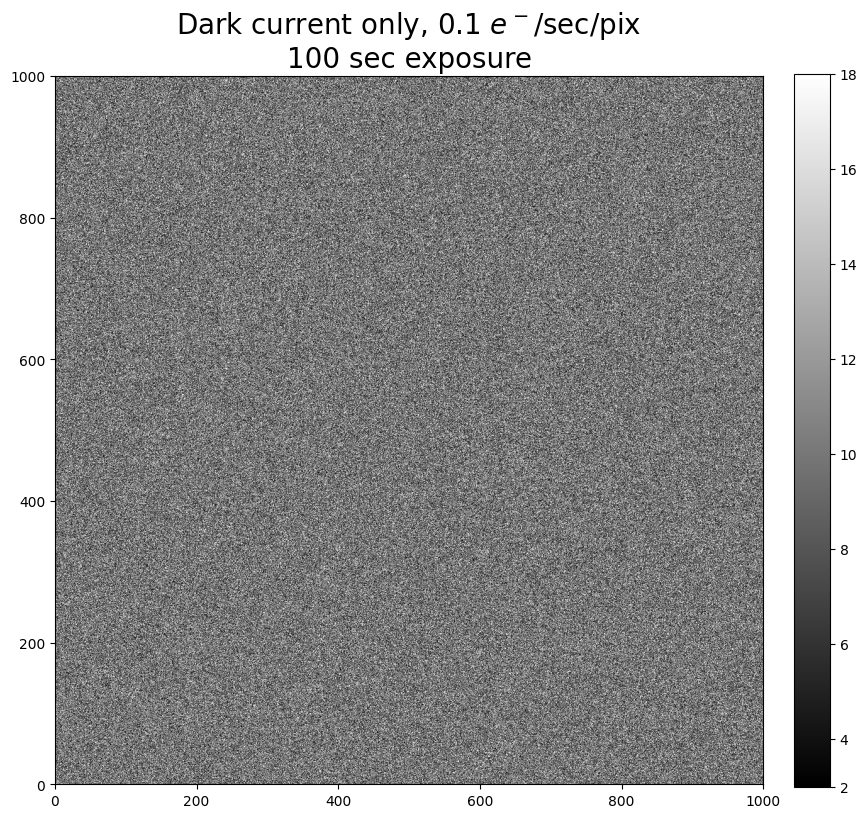

In [45]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
show_image(dark_only, cmap='gray')
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');

Note that the central value of the image colorbar is 10, the product of the dark
current and the exposure time.

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

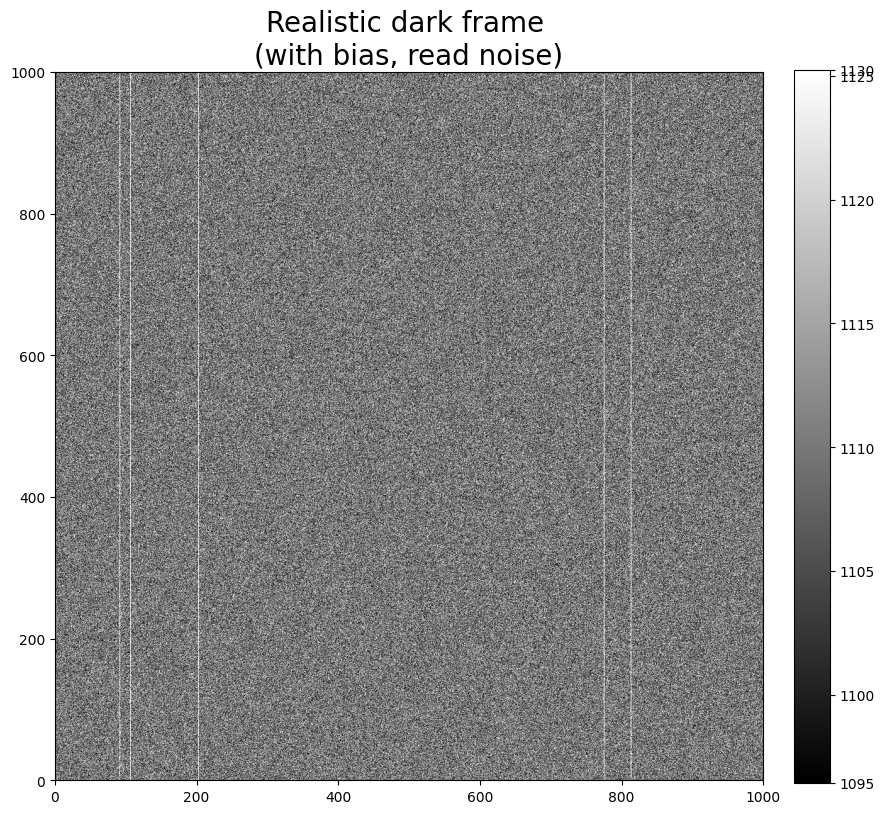

In [46]:
dark_bias_noise_im = bias_noise_im + dark_only
show_image(dark_bias_noise_im, cmap='gray')
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')

## Sky background

The amount of sky background depends on the atmospheric conditions (humidity,
presence of light clouds, fires upwind from the observatory), the light sources
in the sky (the Moon), and light sources in the surrounding area (cities). It
may be uniform across the frame or it may not be, depending on the conditions.

The function below generates some sky background. Each time you run it you'll
get slightly different results (even if you keep the desired amount of sky
counts the same) because the counts from a light source follow a Poisson
distribution.

The amount of sky background is directly proportional to the exposure time. In
the function below however, you input the desired number of sky counts.

It's not at all unusual to have a gradient in the sky across the image, but that
effect is not simulated here.

In [47]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).

    Parameters
    ----------

    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = noise_rng.poisson(sky_counts * gain, size=image.shape) / gain

    return sky_im

Text(0.5, 1.0, 'Sky background only, 20 counts input')

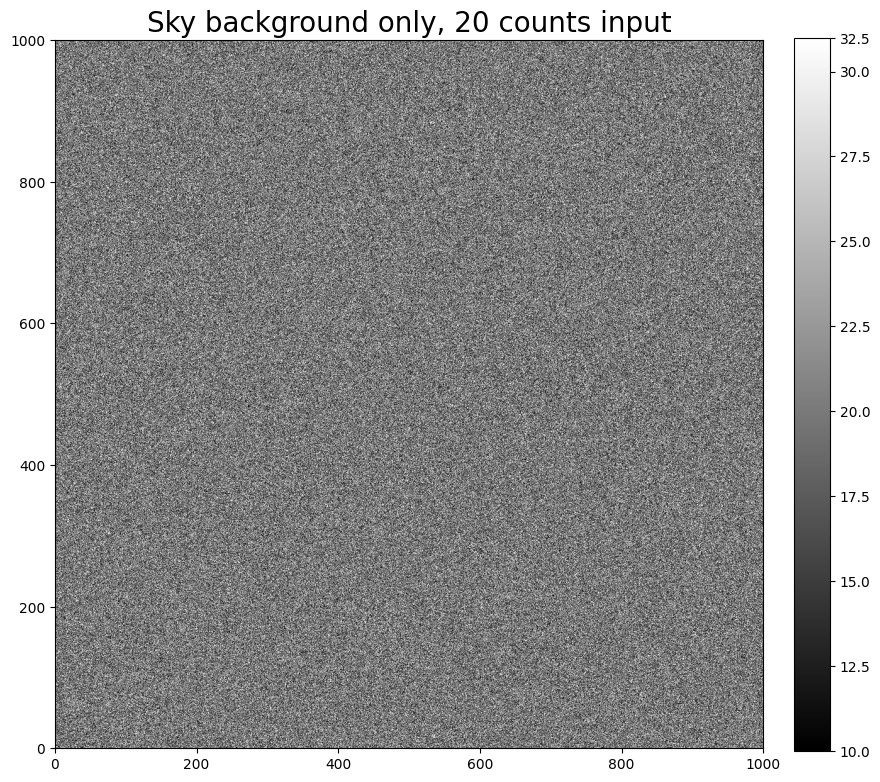

In [48]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
show_image(sky_only, cmap='gray')
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)

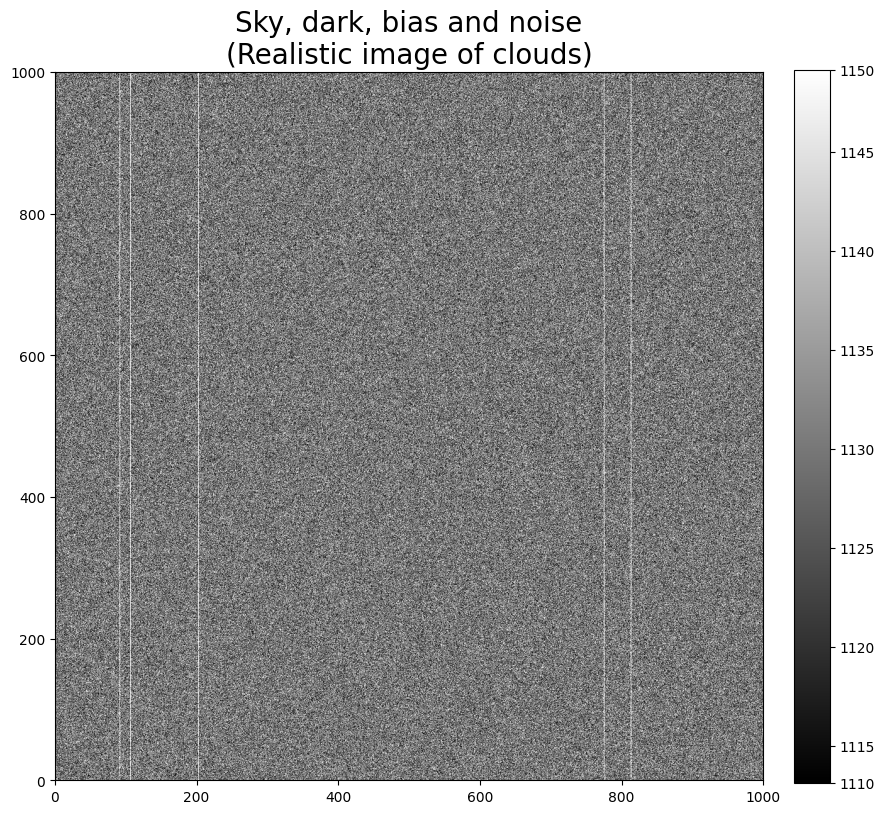

In [49]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
show_image(sky_dark_bias_noise_im, cmap='gray')
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20);

### Summary of the backgrounds in an astronomical image

Note that the central value of the pixels in the "realistic" cloud image above,
1130 or so, is the sum of the:

+ bias level (1100 counts)
+ dark current (10 counts, which is 0.1 e/sec/pix $\times$ 100 sec, divided by
the gain of 1 e/count)
+ sky counts (20 counts)

The distribution of counts around that is determined by the read noise (5
electrons) and the expected width of a Poisson distribution for the sky counts,
which is the square root of the number of those counts, $\sqrt{20} \approx 4.5$.
Add those in quadrature and you get about 6.7.

### Interactive demo

The cell below sets up an interactive demo that lets you change the value of
read noise and other parameters to see the effect that changing them has on the
resulting image.

In [51]:
from ipywidgets import interactive, interact

# @interact(bias_level=(1000,1200,10), dark=(0.01,1,0.01), sky_counts=(0, 300, 10),
#           gain=(0.5, 3.0, 0.1), read=(0, 50, 2.0),
#           exposure=(0, 300, 10))
def complete_image(bias_level=1100, read=10.0, gain=1, dark=0.1,
                   exposure=30, hot_pixels=True, sky_counts=200):
    synthetic_image = np.zeros([500, 500])
    show_image(synthetic_image +
               read_noise(synthetic_image, read) +
               bias(synthetic_image, bias_level, realistic=True) +
               dark_current(synthetic_image, dark, exposure, hot_pixels=hot_pixels) +
               sky_background(synthetic_image, sky_counts),
               cmap='gray',
               figsize=None)

i = interactive(complete_image, bias_level=(1000,1200,10), dark=(0.0,1,0.1), sky_counts=(0, 300, 50),
          gain=(0.5, 3.0, 0.25), read=(0, 50, 5.0),
          exposure=(0, 300, 30))

for kid in i.children:
    try:
        kid.continuous_update = False
    except KeyError:
        pass
#i

## Add some "stars"

The "stars" we'll add below are essentially just (round) Gaussian sources. The
function that does most of the work is from [photutils](https://photutils.readthedocs.io/en/stable/index.html),
which we'll return to later for doing photometry.



In [52]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_model_image, make_model_params
    from photutils.psf import CircularGaussianPSF

    psf_model = CircularGaussianPSF(fwhm=9.4)
    max_counts *= 100  # approx. peak amplitude to flux
    params = make_model_params(image.shape, n_sources=number,
                               flux=(max_counts / 10, max_counts),
                               min_separation=20,
                               border_size=20, seed=12345)

    return make_model_image(image.shape, psf_model, params,
                            progress_bar=True)

Add model sources:   0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Stars only')

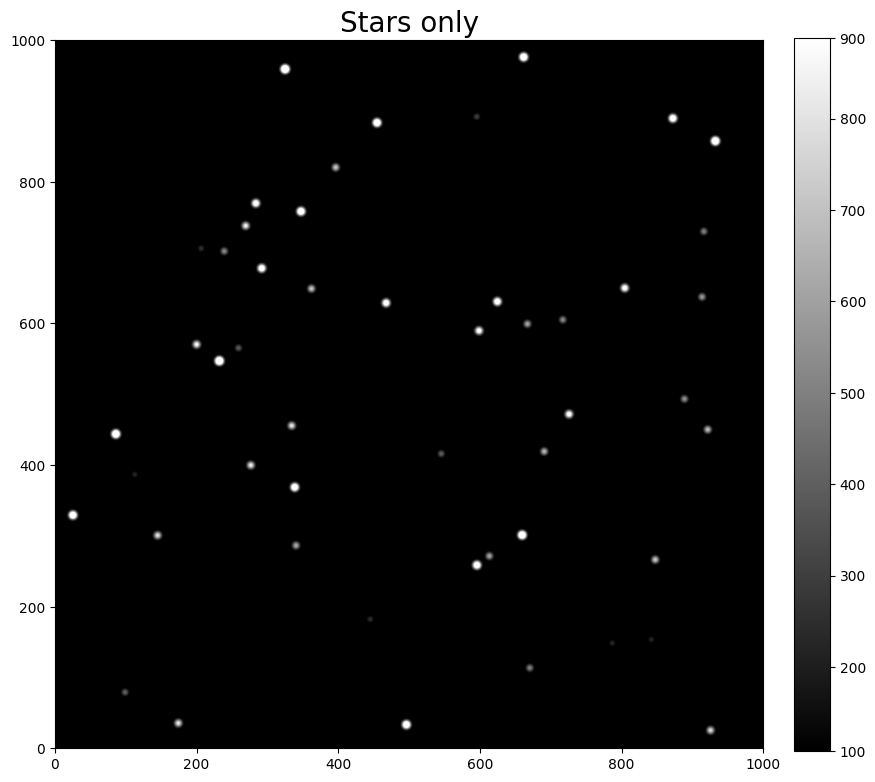

In [53]:
stars_only = stars(synthetic_image, 50, max_counts=2000)
show_image(stars_only, cmap='gray', percu=99.9)
plt.title('Stars only'.format(stars_only), fontsize=20)

In [54]:
stars_with_background = sky_dark_bias_noise_im + stars_only

Text(0.5, 1.0, 'Stars with noise, bias, dark, sky')

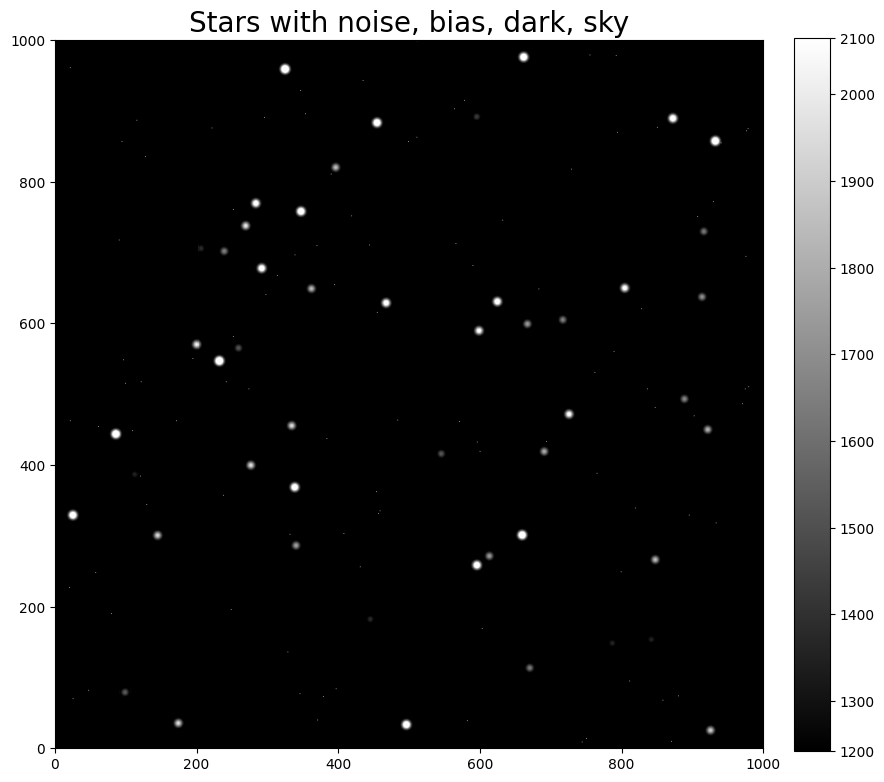

In [55]:
show_image(stars_with_background, cmap='gray', percu=99.9)
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)

### Discussion

In the image above the single-pixel bright dots are hot pixels while the
remaining dots that are larger than a pixel are simulated stars.

## Summary

Everything we have included so far has been additive. Symbolically, the
simulated image above was built like this:

$$
\text{image} = \text{bias} + \text{noise} + \text{dark current} + \text{sky} + \text{stars}
$$

Extracting the science (i.e. the stars) is in principle a matter of subtraction:

$$
\text{stars} =  \text{image} - \text{bias} - \text{noise} - \text{dark current} - \text{sky}
$$

There are a few complications:

1. There are multiplicative effects that will be discussed in the next notebook.
2. The way to measure each of the the things we need to subtract (bias and dark
current) is to take images, each of which includes read noise. That can be
minimized by combining several calibration images.
3. There is no way to subtract the read noise because it is random.